In [3]:
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
import numba
import scipy.optimize
import scipy.signal
from scipy.optimize import leastsq, curve_fit
from scipy.stats import pearsonr
from scipy.signal import hilbert
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.signal import find_peaks
from matplotlib.collections import PolyCollection
# import imageio.v2 as imageio
from PIL import Image
import matplotlib.patches as mpatches
from scipy import integrate
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

In [4]:
import os, subprocess
def svg_to_emf(svg_figpath):
    '''1. 如果是.svg的绝对路径，True改为False；
       2. inlscape.exe的文件路径中必须是双斜杠\\，单斜杠\会出错；
       3. subprocess.call中的shell=True不可省略，否则会报错。'''
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        os.remove(svg_figpath)

def powerfit(x, ain1, bin1, cin1):
        return ain1*x**bin1 + cin1

def poly2fit(x, p1, p2, p3):
    y = p1*x**2 + p2*x + p3
    return y
def poly3fit(x, p1, p2, p3, p4):
    y = p1*x**3 + p2*x**2 + p3*x + p4
    return y

def poly1fit(x, p1, p2):
    y = p1*x + p2
    return y

def poly5fit(x, p1, p2, p3, p4, p5, p6):
    y = p1*x**5 + p2*x**4 + p3*x**3 + p4*x**2 + p5*x + p6
    return y

def gauss2fit(x, a1, b1, c1, a2, b2, c2):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2)
    return y
def gauss3fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2)
    return y
def gauss4fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2) + a4*np.exp(-((x-b4)/c4)**2)
    return y

def exp2fit(x, a, b, c, d):
    y = a*np.exp(b*x) + c*np.exp(d*x)
    return y


@numba.njit
def generateOUNoise_Liu(tvar): 
    tau_OU = 5 # 5ms
    OUNoise = np.zeros_like(tvar)
    dt1 = tvar[1] - tvar[0] # ms
    for i in range(len(OUNoise)-1):
        OUNoise[i+1] = OUNoise[i] - (OUNoise[i]/tau_OU)*dt1 + np.sqrt(dt1)*np.sqrt(2/tau_OU)*np.random.randn()   
    return OUNoise
    
def calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=19.0):
    '''峰值时刻作为放电时刻'''
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore) # 逻辑与，上述两者逻辑与为真代表为局部最大值，是放电峰值可能存在的时刻
    largerThanThresh = vsoma > Vth  # 定义一个远大于放电阈值的电压值
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) # 放电峰值时刻二进制序列
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]
    firingRate = 1e3 * spikeNumber / (tvar[-1] - tvar[0])
    return spikeNumber, firingRate, spikeInds, outputSpikeTimes

def calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0):
    dt = tvar[1] - tvar[0]
    nDtPer1ms = int(1/dt)
    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence1 = np.sum(spikeCountSequence, axis=1)

    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence2 = np.sum(spikeCountSequence, axis=1)
    
    outputCorrelation   = pearsonr(spikeCountSequence1, spikeCountSequence2)[0]
    return outputCorrelation

def calcTacsSpikePLV(vsoma, Evar, tvar, Vth=19.0):
    '''采用希尔伯特变换, 0°对应了电场波形的峰值, 90°对应了电场下降边缘'''
    analyticSignal = hilbert(Evar)
    tacsInstantaneousPhase = np.angle(analyticSignal)  # 计算结果为弧度值,-π~π
    _, _, spikeIndex, spikeTime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=Vth)
    spikePhaseRadian = tacsInstantaneousPhase[spikeIndex]
    spikePhaseRadian[spikePhaseRadian < 0 ] += 2*np.pi
    pluralPLV = np.mean(np.exp(1j*spikePhaseRadian))
    spikePhaseDegree = np.rad2deg(spikePhaseRadian)
    fieldSpikePLV = np.abs(pluralPLV)
    
    return fieldSpikePLV, spikePhaseDegree, pluralPLV

'''
Paper: Weak electric fields promote resonance in neuronal spiking activity: Analytical results from two-compartment cell and network models
'''
@numba.njit
def twoCompModel(params2C, vs, vd, Is=0.0, Id=0.0, E=0.0, dt=0.1):
    # Cs, Cd, Gs, Gd, Gi = params2C['Cs'], params2C['Cd'], params2C['Gs'], params2C['Gd'], params2C['Gj']
    # Gexp, DeltaT, VT   = params2C['Gexp'], params2C['DeltaT'], params2C['VT']
    # # Vr, Vth            = params2C['Vr'], params2C['Vth']
    # Delta, DeltaV      = params2C['Delta'], params2C['DeltaV']
    Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV = params2C
    vsn = vs + dt * ( Gi*(vd-vs-Delta*E) - Gs*vs + Is + Gexp*DeltaT*np.exp((vs-VT)/DeltaT)) / Cs
    vdn = vd + dt * (-Gi*(vd-vs-Delta*E) - Gd*vd + Id) / Cd
    return vsn, vdn
    
@numba.njit
def runModel(params2C=np.ones(1), dt=0.01, tvar=0., Is=0.0, Id=0.0, Evar=0.0):
    Vr, Vth  = params2C[-2], params2C[-1]
    vs, vd   = 0, 0
    vsoma, vdend = np.zeros_like(tvar), np.zeros_like(tvar)
    for i, t in enumerate(tvar):
        vs, vd = twoCompModel(params2C[0:-2], vs, vd, Is=Is[i], Id=Id[i], E=Evar[i], dt=dt)
        if vs > Vth:
            vs = Vr
        vsoma[i], vdend[i] = vs, vd
        
    return vsoma, vdend

params2C = np.load('data/params2C.npy')

In [5]:
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth

(9.886869516727902e-12,
 2.8879148494157734e-11,
 2.4824172059870596e-10,
 8.816311362152411e-10,
 1.211620933213355e-09,
 3.295623172242634e-10,
 0.0015,
 0.01,
 0.0003241105125653797,
 0.0,
 0.003400000000000002,
 0.02)

# Figure 2: 相关性计算示意图

## 相关性输入时序

In [203]:
dt       = 0.01/1e3                     # second
duration = 1                         # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 0, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3

C:\Users\Snowp\Desktop\figures\figure2_input.svg


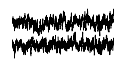

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.plot(tvar, Id1*1e12+200, color='k', lw=0.5)
ax.plot(tvar, Id2*1e12, color='k', lw=0.5)
ax.axis('off')
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure2_input.svg',format='svg',transparent=True,dpi=300,bbox_inches='tight')
# svg_to_emf(r'C:\Users\Snowp\Desktop\figures\figure2_input.svg')

## 相关性输出时序

In [237]:
dt       = 0.01/1e3                     # second
duration = 0.4                        # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 0, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3

C:\Users\Snowp\Desktop\figures\figure2_input.svg


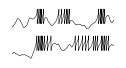

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.plot(tvar, vsoma1+30, color='k', lw=0.5)
ax.plot(tvar, vsoma2, color='k', lw=0.5)
ax.axis('off')
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure2_output.svg',format='svg',transparent=True,dpi=300,bbox_inches='tight')
# svg_to_emf(r'C:\Users\Snowp\Desktop\figures\figure2_output.svg')

# Figure 3: 模型验证和参数范围确认

## Figure 3(a): 电场极化响应——电场强度

In [170]:
%%time
'''电场强度诱发的响应'''
list_AE = np.arange(0, 21, 2.5)
list_fE = [10, 20, 50]

matrixApSoma = np.zeros((len(list_fE), len(list_AE)))
matrixApDend = np.zeros((len(list_fE), len(list_AE)))
for i in range(len(list_fE)):
    for j in range(len(list_AE)):
        dt       = 0.01/1e3                     # second
        duration = 2                        # second
        tvar     = np.arange(0, duration, dt)   # second
        AE, fE, phiE   = list_AE[j], list_fE[i], 0
        Is   = np.zeros_like(tvar)              # A
        Id   = np.zeros_like(tvar) 
        Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
        vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
        tvar, vsoma, vdend = tvar*1e3, vsoma*1e3, vdend*1e3
        if AE == 0:
            matrixApSoma[i, j] = 0
            matrixApDend[i, j] = 0
        else:
            matrixApSoma[i, j] = vsoma[find_peaks(vsoma)[0][-1]]
            matrixApDend[i, j] = vdend[find_peaks(vdend)[0][-1]]

Wall time: 288 ms


## Figure 3(b): 电场极化响应——电场频率

In [171]:
%%time
list_fE = np.arange(1, 100.0, 2)
matrixLambdapSoma = np.zeros_like(list_fE)
matrixLambdapDend = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE, fE, phiE   = 10, list_fE[i], 0
    dt = 0.01/1e3  
    if fE <= 5:
        duration = 10
    else:
        duration = 2                     
    tvar     = np.arange(0, duration, dt)  
    Is   = np.zeros_like(tvar)             
    Id   = np.zeros_like(tvar) 
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE)
    vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    tvar, vsoma, vdend = tvar*1e3, vsoma*1e3, vdend*1e3
    matrixLambdapSoma[i] = vsoma[find_peaks(vsoma)[0][-1]]/AE
    matrixLambdapDend[i] = vdend[find_peaks(vdend)[0][-1]]/AE

Wall time: 657 ms


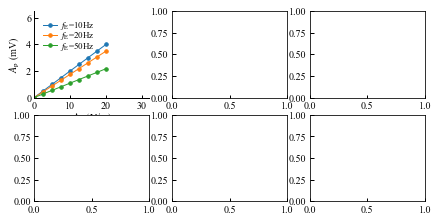

In [173]:
fig, ax = plt.subplots(2, 3, figsize=(7, 3.5))
labelpad = 1
'''Figure 3(a): 胞体极化强度——电场强度'''
list_AE = np.arange(0, 21, 2.5)
list_fE = [10, 20, 50]
for i in range(matrixApSoma.shape[0]):
    ax[0, 0].plot(list_AE, matrixApSoma[i], marker='o', ms=3.5, lw=1, label=r'$\mathit{f}_{\mathrm{E}}$=%2dHz' % list_fE[i])
ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=-0.2, handletextpad=0.4, borderpad=0.5, handlelength=1.5)
ax[0, 0].set_ylim(0, 6.5)
ax[0, 0].set_yticks([0, 2, 4, 6])
ax[0, 0].set_xlim(0, 32)
ax[0, 0].set_xticks([0, 10, 20, 30])
ax[0, 0].tick_params(pad=3)
ax[0, 0].set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
ax[0, 0].set_ylabel(r'$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=labelpad+4)
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['bottom'].set_linewidth(linewidth)
ax[0, 0].spines['left'].set_linewidth(linewidth)

## Figure 3(a-f) 绘图

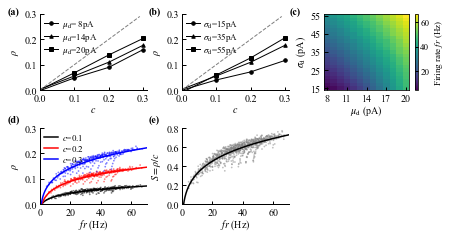

In [24]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1
fig, ax = plt.subplots(2, 3, figsize=(7, 3.5))

list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''Figure 3(a): rou-c with different mu'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0, 0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], ms=3.5, lw=1, label=r'$\mu_{\mathrm{d}}$=%2dpA' % list_mu[mu_index[i]])
ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[0, 0].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[0, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[0, 0].set_xlim(0, 0.31)
ax[0, 0].set_ylim(0, 0.3)
ax[0, 0].set_xticks([0, 0.1, 0.2, 0.3])
ax[0, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[0, 0].tick_params(pad=3)
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['bottom'].set_linewidth(linewidth)
ax[0, 0].spines['left'].set_linewidth(linewidth)

'''Figure 3(b): rou-c with different sigma'''
sigma_index = [0, 11, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0, 1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], ms=3.5, lw=1, label='$\sigma_{\mathrm{d}}$=%2dpA' % list_sigma[sigma_index[i]])
ax[0, 1].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 1].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[0, 1].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[0, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[0, 1].set_xticks([0, 0.1, 0.2, 0.3])
ax[0, 1].set_yticks([0, 0.1, 0.2, 0.3])
ax[0, 1].set_xlim(0, 0.31)
ax[0, 1].set_ylim(0, 0.3)
ax[0, 1].tick_params(pad=3)
ax[0, 1].spines['top'].set_color('none')
ax[0, 1].spines['right'].set_color('none')
ax[0, 1].spines['bottom'].set_linewidth(linewidth)
ax[0, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(c): 确定刺激参数范围'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[0, 2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[0, 2], label=r'Firing rate $fr$ (Hz)')
cbar.set_ticks([20, 40, 60], fontsize=9)
cbar.set_label(r'Firing rate $fr$ (Hz)', fontsize=9, labelpad=labelpad+2)
cbar.ax.tick_params(labelsize=9, pad=2)
ax[0, 2].set_xlabel(r'$\mu_{\mathrm{d}}$ (pA)', fontsize=10, labelpad=labelpad)
ax[0, 2].set_ylabel(r'$\sigma_{\mathrm{d}}$ (pA)', fontsize=10, labelpad=labelpad+2)
ax[0, 2].set_xticks(np.arange(8, 20+1, 3))
ax[0, 2].set_yticks(np.arange(15, 55+1, 10))
ax[0, 2].tick_params(pad=3)


'''Figure 3(d): rou-fr with different c'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
colors=['k', 'r', 'b']
for i in range(3):
    ax[1, 0].scatter(list_x[i], list_y[i], color=colors[i], s=3, ec=None, alpha=0.5)
    ax[1, 0].plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1.5, label='$c$=%.1f' % list_c[i+1])
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 0].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 0].set_xlim(0, 70)
ax[1, 0].set_ylim(0., 0.3)
ax[1, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 0].set_xticks([0, 20, 40, 60])
ax[1, 0].tick_params(pad=3)
ax[1, 0].spines['top'].set_color('none')
ax[1, 0].spines['right'].set_color('none')
ax[1, 0].spines['bottom'].set_linewidth(linewidth)
ax[1, 0].spines['left'].set_linewidth(linewidth)


'''Figure 3(e): susceptibiliy-firing rate relationship'''
list_x, list_y = np.array([]), np.array([])
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou   = data_rou / list_c[i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    list_x = np.hstack((list_x, data_fr))
    list_y = np.hstack((list_y, data_rou))
xtemp       = sorted(enumerate(list_x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(list_x))
y           = np.array(multi_piker(list_y))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit        = powerfit(xfit, *best_vals)
ax[1, 1].scatter(x, y, color='grey', s=3, ec=None, alpha=0.5)
ax[1, 1].plot(xfit, yfit, color='k', lw=1.5)
ax[1, 1].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 1].set_ylabel(r'$S=\rho/c$', fontsize=10, labelpad=labelpad+2)
ax[1, 1].set_xlim(0, 70)
ax[1, 1].set_ylim(0., 0.8)
ax[1, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax[1, 1].set_xticks([0, 20, 40, 60])
ax[1, 1].tick_params(pad=3)
ax[1, 1].spines['top'].set_color('none')
ax[1, 1].spines['right'].set_color('none')
ax[1, 1].spines['bottom'].set_linewidth(linewidth)
ax[1, 1].spines['left'].set_linewidth(linewidth)



'''Figure 3(f): None'''
ax[1, 2].axis('off')

fig.text(0.06, 0.88, '(a)', fontsize=10, fontweight='bold')
fig.text(0.06, 0.45, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.88, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.45, '(e)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.88, '(c)', fontsize=10, fontweight='bold')
# fig.text(0.62, 0.45, '(f)', fontsize=10, fontweight='bold')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.33, hspace=0.5)
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure3.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

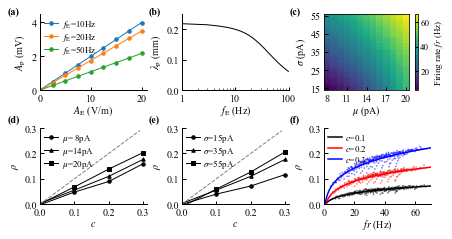

In [183]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1
fig, ax = plt.subplots(2, 3, figsize=(7, 3.5))

'''Figure 3(a): 胞体极化强度——电场强度'''
list_AE = np.arange(0, 21, 2.5)
list_fE = [10, 20, 50]
for i in range(matrixApSoma.shape[0]):
    ax[0, 0].plot(list_AE, matrixApSoma[i], marker='o', ms=3.5, lw=1, label=r'$\mathit{f}_{\mathrm{E}}$=%2dHz' % list_fE[i])
ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].set_ylim(0, 4.5)
ax[0, 0].set_yticks([0, 2, 4])
ax[0, 0].set_xlim(0, 21)
ax[0, 0].set_xticks([0, 10, 20])
ax[0, 0].tick_params(pad=3)
ax[0, 0].set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
ax[0, 0].set_ylabel(r'$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=labelpad+4)
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['bottom'].set_linewidth(linewidth)
ax[0, 0].spines['left'].set_linewidth(linewidth)

'''Figure 3(b): 胞体极化长度——电场频率'''
list_fE = np.arange(1, 100.0, 2)
ax[0, 1].semilogx(list_fE, matrixLambdapSoma, lw=1., color='k')
ax[0, 1].set_ylim(0, 0.25)
ax[0, 1].set_yticks([0, 0.1, 0.2])
ax[0, 1].set_xlim(1, 100)
ax[0, 1].set_xticks([1, 10, 100])
ax[0, 1].set_xticklabels(['1', '10', '100'], fontsize=10)
ax[0, 1].tick_params(pad=3)
ax[0, 1].set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=labelpad)
ax[0, 1].set_ylabel(r'$\mathit{\lambda}_{\mathrm{p}}$ (mm)', fontsize=10, labelpad=labelpad+2)
ax[0, 1].spines['top'].set_color('none')
ax[0, 1].spines['right'].set_color('none')
ax[0, 1].spines['bottom'].set_linewidth(linewidth)
ax[0, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(c): 确定刺激参数范围'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[0, 2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[0, 2], label=r'Firing rate $fr$ (Hz)')
cbar.set_ticks([20, 40, 60], fontsize=9)
cbar.set_label(r'Firing rate $fr$ (Hz)', fontsize=9, labelpad=labelpad+2)
cbar.ax.tick_params(labelsize=9, pad=2)
ax[0, 2].set_xlabel(r'$\mu$ (pA)', fontsize=10, labelpad=labelpad)
ax[0, 2].set_ylabel(r'$\sigma$ (pA)', fontsize=10, labelpad=labelpad+2)
ax[0, 2].set_xticks(np.arange(8, 20+1, 3))
ax[0, 2].set_yticks(np.arange(15, 55+1, 10))
ax[0, 2].tick_params(pad=3)


'''Figure 3(d): 输出相关性——输入相关性，不同输入均值'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1, 0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], ms=3.5, lw=1, label=r'$\mu$=%2dpA' % list_mu[mu_index[i]])
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 0].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[1, 0].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[1, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 0].set_xlim(0, 0.31)
ax[1, 0].set_ylim(0, 0.3)
ax[1, 0].set_xticks([0, 0.1, 0.2, 0.3])
ax[1, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 0].tick_params(pad=3)
ax[1, 0].spines['top'].set_color('none')
ax[1, 0].spines['right'].set_color('none')
ax[1, 0].spines['bottom'].set_linewidth(linewidth)
ax[1, 0].spines['left'].set_linewidth(linewidth)


'''Figure 3(e): 输出相关性——输入相关性，不同输入方差'''
sigma_index = [0, 11, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1, 1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], ms=3.5, lw=1, label='$\sigma$=%2dpA' % list_sigma[sigma_index[i]])
ax[1, 1].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 1].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[1, 1].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[1, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 1].set_xticks([0, 0.1, 0.2, 0.3])
ax[1, 1].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 1].set_xlim(0, 0.31)
ax[1, 1].set_ylim(0, 0.3)
ax[1, 1].tick_params(pad=3)
ax[1, 1].spines['top'].set_color('none')
ax[1, 1].spines['right'].set_color('none')
ax[1, 1].spines['bottom'].set_linewidth(linewidth)
ax[1, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(f): 输出相关性——平均放电率，不同输入相关性条件下'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
colors=['k', 'r', 'b']
for i in range(3):
    ax[1, 2].scatter(list_x[i], list_y[i], color=colors[i], s=3, ec=None, alpha=0.5)
    ax[1, 2].plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1.5, label='$c$=%.1f' % list_c[i+1])
ax[1, 2].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 2].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 2].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 2].set_xlim(0, 70)
ax[1, 2].set_ylim(0., 0.3)
ax[1, 2].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 2].set_xticks([0, 20, 40, 60])
ax[1, 2].tick_params(pad=3)
ax[1, 2].spines['top'].set_color('none')
ax[1, 2].spines['right'].set_color('none')
ax[1, 2].spines['bottom'].set_linewidth(linewidth)
ax[1, 2].spines['left'].set_linewidth(linewidth)

fig.text(0.06, 0.88, '(a)', fontsize=10, fontweight='bold')
fig.text(0.06, 0.45, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.88, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.45, '(e)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.88, '(c)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.45, '(f)', fontsize=10, fontweight='bold')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.33, hspace=0.5)
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure3.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

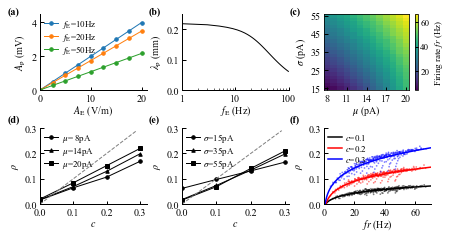

In [181]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1
fig, ax = plt.subplots(2, 3, figsize=(7, 3.5))

'''Figure 3(a): 胞体极化强度——电场强度'''
list_AE = np.arange(0, 21, 2.5)
list_fE = [10, 20, 50]
for i in range(matrixApSoma.shape[0]):
    ax[0, 0].plot(list_AE, matrixApSoma[i], marker='o', ms=3.5, lw=1, label=r'$\mathit{f}_{\mathrm{E}}$=%2dHz' % list_fE[i])
ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].set_ylim(0, 4.5)
ax[0, 0].set_yticks([0, 2, 4])
ax[0, 0].set_xlim(0, 21)
ax[0, 0].set_xticks([0, 10, 20])
ax[0, 0].tick_params(pad=3)
ax[0, 0].set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
ax[0, 0].set_ylabel(r'$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=labelpad+4)
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['bottom'].set_linewidth(linewidth)
ax[0, 0].spines['left'].set_linewidth(linewidth)

'''Figure 3(b): 胞体极化长度——电场频率'''
list_fE = np.arange(1, 100.0, 2)
ax[0, 1].semilogx(list_fE, matrixLambdapSoma, lw=1., color='k')
ax[0, 1].set_ylim(0, 0.25)
ax[0, 1].set_yticks([0, 0.1, 0.2])
ax[0, 1].set_xlim(1, 100)
ax[0, 1].set_xticks([1, 10, 100])
ax[0, 1].set_xticklabels(['1', '10', '100'], fontsize=10)
ax[0, 1].tick_params(pad=3)
ax[0, 1].set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=labelpad)
ax[0, 1].set_ylabel(r'$\mathit{\lambda}_{\mathrm{p}}$ (mm)', fontsize=10, labelpad=labelpad+2)
ax[0, 1].spines['top'].set_color('none')
ax[0, 1].spines['right'].set_color('none')
ax[0, 1].spines['bottom'].set_linewidth(linewidth)
ax[0, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(c): 确定刺激参数范围'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[0, 2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[0, 2], label=r'Firing rate $fr$ (Hz)')
cbar.set_ticks([20, 40, 60], fontsize=9)
cbar.set_label(r'Firing rate $fr$ (Hz)', fontsize=9, labelpad=labelpad+2)
cbar.ax.tick_params(labelsize=9, pad=2)
ax[0, 2].set_xlabel(r'$\mu$ (pA)', fontsize=10, labelpad=labelpad)
ax[0, 2].set_ylabel(r'$\sigma$ (pA)', fontsize=10, labelpad=labelpad+2)
ax[0, 2].set_xticks(np.arange(8, 20+1, 3))
ax[0, 2].set_yticks(np.arange(15, 55+1, 10))
ax[0, 2].tick_params(pad=3)




list_c = [0.0, 0.1, 0.2, 0.3]
list_mu = np.arange(8, 20+0.1, 1)
list_sigma = np.arange(15, 55+1, 2)
res        = np.load('data/times30_c00-03_mu8-20pA_sigma15-55pA_AE10_fE10.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''Figure 3(d): 输出相关性——输入相关性，不同输入均值'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1, 0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], ms=3.5, lw=1, label=r'$\mu$=%2dpA' % list_mu[mu_index[i]])
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 0].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[1, 0].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[1, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 0].set_xlim(0, 0.32)
ax[1, 0].set_ylim(0, 0.3)
ax[1, 0].set_xticks([0, 0.1, 0.2, 0.3])
ax[1, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 0].tick_params(pad=3)
ax[1, 0].spines['top'].set_color('none')
ax[1, 0].spines['right'].set_color('none')
ax[1, 0].spines['bottom'].set_linewidth(linewidth)
ax[1, 0].spines['left'].set_linewidth(linewidth)


'''Figure 3(e): 输出相关性——输入相关性，不同输入方差'''
sigma_index = [0, 10, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1, 1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], ms=3.5, lw=1, label='$\sigma$=%2dpA' % list_sigma[sigma_index[i]])
ax[1, 1].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 1].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[1, 1].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[1, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 1].set_xticks([0, 0.1, 0.2, 0.3])
ax[1, 1].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 1].set_xlim(0, 0.31)
ax[1, 1].set_ylim(0, 0.3)
ax[1, 1].tick_params(pad=3)
ax[1, 1].spines['top'].set_color('none')
ax[1, 1].spines['right'].set_color('none')
ax[1, 1].spines['bottom'].set_linewidth(linewidth)
ax[1, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(f): 输出相关性——平均放电率，不同输入相关性条件下'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
colors=['k', 'r', 'b']
for i in range(3):
    ax[1, 2].scatter(list_x[i], list_y[i], color=colors[i], s=3, ec=None, alpha=0.5)
    ax[1, 2].plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1.5, label='$c$=%.1f' % list_c[i+1])
ax[1, 2].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 2].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 2].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 2].set_xlim(0, 70)
ax[1, 2].set_ylim(0., 0.3)
ax[1, 2].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 2].set_xticks([0, 20, 40, 60])
ax[1, 2].tick_params(pad=3)
ax[1, 2].spines['top'].set_color('none')
ax[1, 2].spines['right'].set_color('none')
ax[1, 2].spines['bottom'].set_linewidth(linewidth)
ax[1, 2].spines['left'].set_linewidth(linewidth)

fig.text(0.06, 0.88, '(a)', fontsize=10, fontweight='bold')
fig.text(0.06, 0.45, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.88, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.45, '(e)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.88, '(c)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.45, '(f)', fontsize=10, fontweight='bold')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.33, hspace=0.5)
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure3.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

[ 0.29859562 34.93043395  0.1767504 ]


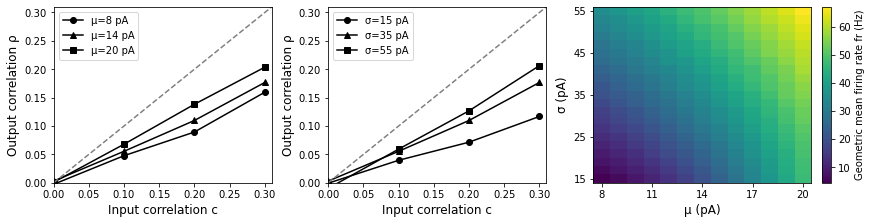

In [4]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
print(np.mean(res, axis=0)[3, 6, 11])
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
'''ρ-c with different μ (σ = 35 pA)'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], label='μ=%.f pA' % list_mu[mu_index[i]])
ax[0].legend(fontsize=10)
ax[0].plot([0, 0.31], [0, 0.31], ls='--', color='grey')
ax[0].set_xlabel('Input correlation c', fontsize = 12)
ax[0].set_ylabel('Output correlation ρ', fontsize = 12)
ax[0].set_xlim(0, 0.31)
ax[0].set_ylim(0, 0.31)

'''ρ-c with different σ (μ = 14 pA)'''
sigma_index = [0, 11, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], label='σ=%.f pA' % list_sigma[sigma_index[i]])
ax[1].legend(fontsize=10) 
ax[1].plot([0, 0.31], [0, 0.31], ls='--', color='grey')
ax[1].set_xlabel('Input correlation c', fontsize = 12)
ax[1].set_ylabel('Output correlation ρ', fontsize = 12)
ax[1].set_xlim(0, 0.31)
ax[1].set_ylim(0, 0.31)

'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[2], label='Geometric mean firing rate fr (Hz)', )
ax[2].set_xlabel('μ (pA)', fontsize = 12)
ax[2].set_ylabel('σ (pA)', fontsize = 12)
ax[2].set_xticks(np.arange(8, 20+1, 3))
ax[2].set_yticks(np.arange(15, 55+1, 10))

(0.0, 0.8)

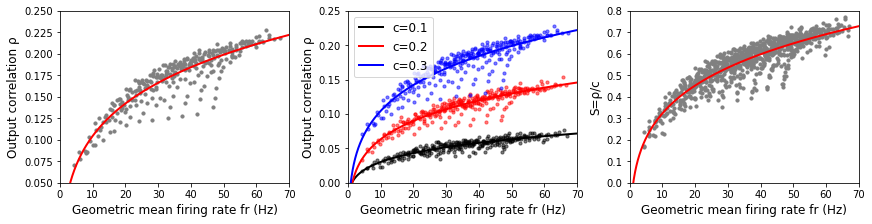

In [5]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
'''positive correlation-firing rate relationship with c=0.3'''
data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][-1] # shape=(mu, sigma), cin=0.3
data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][-1] # shape=(mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_noEF   = powerfit(xfit, *best_vals)
ax[0].scatter(x, y, color='grey', s=10)
ax[0].plot(xfit, yfit_noEF, color='r', lw=2)
ax[0].set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[0].set_xlim(0, 70)
ax[0].set_ylim(0.05, 0.25)

'''correlation-firing rate relationship with different c'''
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
colors=['k', 'r', 'b']
for i in range(3):
    ax[1].scatter(list_x[i], list_y[i], color=colors[i], s=10, alpha=0.5)
    ax[1].plot(list_xfit[i], list_yfit[i], color=colors[i], lw=2, label='c=%.1f' % list_c[i+1])
ax[1].legend(fontsize=12)
ax[1].set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax[1].set_ylabel('Output correlation ρ', fontsize=12)
ax[1].set_xlim(0, 70)
ax[1].set_ylim(0., 0.25)

'''susceptibiliy-firing rate relationship'''
list_x, list_y = np.array([]), np.array([])
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou   = data_rou / list_c[i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    list_x = np.hstack((list_x, data_fr))
    list_y = np.hstack((list_y, data_rou))
xtemp       = sorted(enumerate(list_x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(list_x))
y           = np.array(multi_piker(list_y))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit        = powerfit(xfit, *best_vals)
ax[2].scatter(x, y, color='grey', s=10)
ax[2].plot(xfit, yfit, color='r', lw=2)
ax[2].set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax[2].set_ylabel('S=ρ/c', fontsize=12)
ax[2].set_xlim(0, 70)
ax[2].set_ylim(0., 0.8)

# Figure 4: 现象：引入交流电场是够改变输出相关性

## Figure 4-1: 时序图，50个神经元在有无电场作用下的时序图

In [19]:
%%time
neuronNumber = 25
spikeTimeList_neuron1, spikeTimeList_neuron2 = [], []
for i in range(neuronNumber):
    dt       = 0.01/1e3                     # second
    duration = 1                          # second
    tvar     = np.arange(0, duration, dt)   # second
    AE, fE, phiE   = 0, 10, 0
    c, mud, sigmad = 0.3, 14, 35             # pA
    Is   = np.zeros_like(tvar)              # A
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
    vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
    vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
    tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
    _, _, _, spiketime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
    spikeTimeList_neuron1.append(spiketime)
    _, _, _, spiketime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=19.0)
    spikeTimeList_neuron2.append(spiketime)

Wall time: 627 ms


(-31.731000000000005, 1047.8310000000001, -2.45, 51.45)

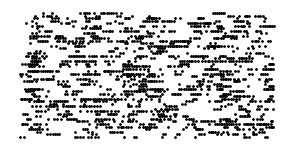

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
for i in range(neuronNumber):
    ax.scatter(spikeTimeList_neuron1[i], [i]*len(spikeTimeList_neuron1[i]), color='k', s=3)
    ax.scatter(spikeTimeList_neuron2[i], [i+neuronNumber]*len(spikeTimeList_neuron2[i]), color='k', s=3)
ax.axis('off')

## Figure 4(a): 没有电场作用下的神经元放电

In [744]:
dt       = 0.01/1e3                     # second
duration = 1                          # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 0, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3

tvar     = np.arange(0, duration, dt)
AE, fE, phiE   = 10, 10, 0
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma3, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma4, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma3, vsoma4 = tvar*1e3, vsoma3*1e3, vsoma4*1e3
# np.savez('data/figure4a_timesequence.npz', vsoma1=vsoma1, vsoma2=vsoma2, vsoma3=vsoma3, vsoma4=vsoma4, tvar=tvar)

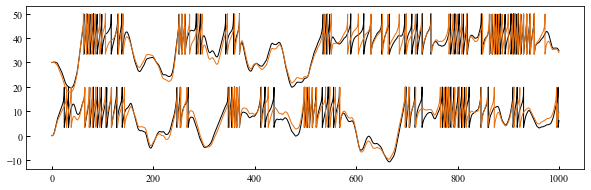

In [745]:
plt.figure(figsize=(10, 3))
plt.plot(tvar, vsoma1+30, color='k', lw=1)
plt.plot(tvar, vsoma2,    color='k', lw=1)
plt.plot(tvar, vsoma3+30, color='#EA700E', lw=1)
plt.plot(tvar, vsoma4,    color='#EA700E', lw=1)

## Figure 4(a-b)

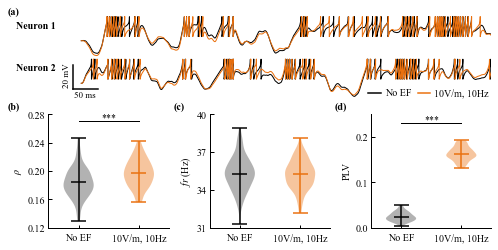

In [942]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1

fig = plt.figure(figsize=(7, 3.5))
shape0, shape1 = 9, 3
ax0 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,0), rowspan=4, colspan=3)
ax1 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,1), rowspan=5, colspan=1)
ax3 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,2), rowspan=5, colspan=1)

'''Figure 4(a): 有无电场作用下时序波形'''
data = np.load('data/figure4a_timesequence.npz')
vsoma1, vsoma2, vsoma3, vsoma4, tvar = data['vsoma1'], data['vsoma2'], data['vsoma3'], data['vsoma4'], data['tvar']
ax0.plot(tvar, vsoma1+35, color='k', lw=1)
ax0.plot(tvar, vsoma2,    color='k', lw=1)
ax0.plot(tvar, vsoma3+35, color='#EA700E', lw=1)
ax0.plot(tvar, vsoma4,    color='#EA700E', lw=1)
ax0.set_xlim(-80, 1000)
ax0.plot([-20, -20], [-5, 15], color='k', lw=1.5)
ax0.plot([-20, 40], [-5, -5], color='k', lw=1.5)
ax0.text(-45, -2, '20 mV', fontsize=9, rotation=90)
ax0.text(-18, -12, '50 ms', fontsize=9, rotation=0)
ax0.axis('off')
ax0.text(-160, 45, 'Neuron 1', fontsize=10, fontweight='bold')
ax0.text(-160, 10, 'Neuron 2', fontsize=10, fontweight='bold')
# square = plt.Rectangle(xy=(690, -13.5), width=310-1, height=12, fill=False, ec='grey', lw=0.5)
# ax0.add_patch(square)
ax0.plot([700, 730], [-8, -8], color='k', lw=1.5)
ax0.text(740, -10.5, 'No EF', fontsize=10)
ax0.plot([820, 850], [-8, -8], color='#EA700E', lw=1.5)
ax0.text(860, -10.5, '10V/m, 10Hz', fontsize=10)


res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-10_fE10.npy')
res     = res.squeeze() # shape=(times, AE, results)
data_rou= res[:, :, 2]  #shape=(times, AE)
data_fr = res[:, :, 1]
data_plv= res[:, :, 3]
'''Figure 4(b): 相关性——有无电场作用'''
positions = np.array([0, 1])
pc1 = ax1.violinplot(data_rou, positions=positions, showmeans=True)
ax1.set_xticks(positions, labels=['No EF', '10V/m, 10Hz'], fontsize=10)
ax1.set_yticks(np.arange(0.12, 0.28+1, 0.04))
ax1.set_ylabel(r'$\rho$', fontsize=10)
ax1.set_ylim(0.12, 0.28)

'''Figure 4(c): 放电率——有无电场作用'''
pc2 = ax2.violinplot(data_fr, positions=positions, showmeans=True)
ax2.set_xticks(positions, labels=['No EF', '10V/m, 10Hz'], fontsize=10)
ax2.set_yticks(np.arange(31, 41, 3))
ax2.set_ylabel('$fr$ (Hz)', fontsize=10)
ax2.set_ylim(31, 40)

'''Figure 4(d): PLV——有无电场作用'''
pc3 = ax3.violinplot(data_plv, positions=positions, showmeans=True)
ax3.set_xticks(positions, labels=['No EF', '10V/m, 10Hz'], fontsize=10)
ax3.set_yticks(np.arange(0, 0.21, 0.1))
ax3.set_ylabel('PLV', fontsize=10)
ax3.set_ylim(0, 0.25)

for item in [ax1, ax2, ax3]:
    item.tick_params('y', pad=3)
    item.tick_params('x', pad=5)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_xlim(0-0.5, 1+0.5)

colors = ['grey', '#EA700E']
for pci in [pc1, pc2, pc3]:
    pci['cmeans'].set_color(['k', '#EA700E'])
    pci['cmaxes'].set_color(['k', '#EA700E'])
    pci['cmins'].set_color(['k', '#EA700E'])
    pci['cbars'].set_color(['k', '#EA700E'])

    pci['bodies'][0].set_facecolor('grey')
    pci['bodies'][0].set_alpha(0.6)
    pci['bodies'][1].set_facecolor('#EA700E')
    pci['bodies'][1].set_alpha(0.4)
plt.tight_layout(w_pad=1, h_pad=1)

ax1.plot([0, 1], [0.27, 0.27], lw=1, color='k')
ax1.text(0.38, .27, '***', fontsize=10)
ax3.plot([0, 1], [0.23, 0.23], lw=1, color='k')
ax3.text(0.38, .23, '***', fontsize=10)

fig.text(0.01, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.01, 0.57, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.57, '(c)', fontsize=10, fontweight='bold')
fig.text(0.66, 0.57, '(d)', fontsize=10, fontweight='bold')

plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure4.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

## Figure 4(b): 有无电场作用下对比图

In [115]:
'''AE=0, 10V/m; fE=10Hz; μ=14pA, σ=35pA, c=0.3'''
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-10_fE10.npy')
res     = res.squeeze() # shape=(times, AE, results)
data_rou= res[:, :, 2]  #shape=(times, AE)
data_fr = res[:, :, 1]
data_plv= res[:, :, 3]

tStat1, pValue1 = scipy.stats.ttest_ind(data_rou[:, 0], data_rou[:, 1])
tStat2, pValue2 = scipy.stats.ttest_ind(data_fr[:, 0], data_fr[:, 1])
tStat3, pValue3 = scipy.stats.ttest_ind(data_plv[:, 0], data_plv[:, 1])
print(pValue1, pValue2, pValue3 )

1.3502687939382283e-05 0.7270725085091575 1.686909463417258e-147


Text(0.5, 1.0, 'p<1.68e-147')

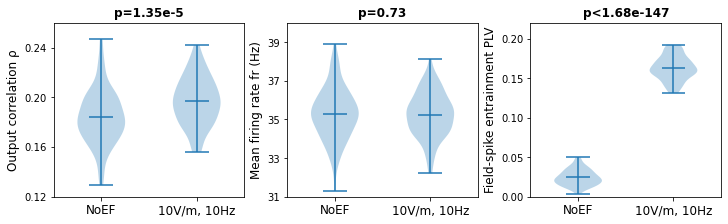

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
positions = np.array([0, 1])
ax[0].violinplot(data_rou, positions=positions, showmeans=True)
ax[0].set_xticks(positions, labels=['NoEF', '10V/m, 10Hz'], fontsize=12)
ax[0].set_yticks(np.arange(0.12, 0.26, 0.04))
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[0].set_ylim(0.12, 0.26)

ax[1].violinplot(data_fr, positions=positions, showmeans=True)
ax[1].set_xticks(positions, labels=['NoEF', '10V/m, 10Hz'], fontsize=12)
ax[1].set_yticks(np.arange(31, 41, 2))
ax[1].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)
ax[1].set_ylim(31, 40)

ax[2].violinplot(data_plv, positions=positions, showmeans=True)
ax[2].set_xticks(positions, labels=['NoEF', '10V/m, 10Hz'], fontsize=12)
ax[2].set_yticks(np.arange(0, 0.21, 0.05))
ax[2].set_ylabel('Field-spike entrainment PLV', fontsize=12)
ax[2].set_ylim(0, 0.22)
for item in ax:
    item.set_xlim(-0.5, 1.5)

ax[0].set_title('p=1.35e-5', fontsize=12, weight='bold')
ax[1].set_title('p=0.73', fontsize=12, weight='bold')
ax[2].set_title('p<1.68e-147', fontsize=12, weight='bold')

# Figure 5: 输出相关性随电场强度和电场频率的变化

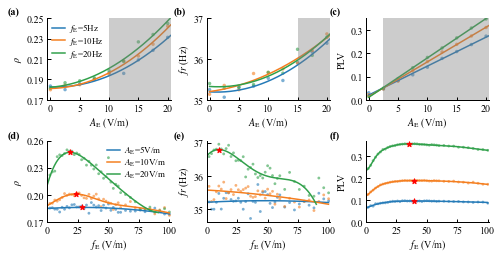

In [1147]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 3
lw = 1.5
fig, ax = plt.subplots(2, 3, figsize=(7, 3.6))
list_AE  = np.arange(0, 20+1, 2.5)
list_fE  = [5, 10, 20, 50]
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE0-20_fE5-10-20-50.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 2, 0, 1)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 2, 0, 1)[1]
data_plv = res.transpose(3, 2, 0, 1)[3]
size=12
alpha=0.6
colors = ['#247AB7', '#F47E1F', '#30A04A']
for i in [0, 1, 2]:
    x, y = list_AE, data_rou[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly2fit(xfit, *best_vals)
    ax[0, 0].scatter(list_AE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 0].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw, label=r'$\mathit{f}_{\mathrm{E}}$=%dHz' % list_fE[i])
    
    x, y = list_AE, data_fr[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly2fit(xfit, *best_vals)
    ax[0, 1].scatter(list_AE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 1].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw)

    x, y = list_AE, data_plv[i].mean(axis=0)
    init_values = [0.1 for i in range(2)]
    best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly1fit(xfit, *best_vals)
    ax[0, 2].scatter(list_AE, data_plv[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 2].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw)

ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].set_ylim(0.17, 0.25)
ax[0, 0].set_yticks(np.arange(0.17, 0.26, 0.02))
ax[0, 1].set_ylim(35, 37)
ax[0, 1].set_yticks(np.arange(35, 37.1, 1))
ax[0, 2].set_ylim(0, 0.35)
ax[0, 2].set_yticks(np.arange(0, 0.35, 0.1))

coordinate = np.array([[10, 0.17], [21, 0.17], [21, 0.25], [10, 0.25]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 0].add_collection(polycol)
coordinate = np.array([[15, 35], [21, 35], [21, 37], [15, 37]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 1].add_collection(polycol)
coordinate = np.array([[2.5, 0], [21, 0], [21, 0.35], [2.5, 0.35]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 2].add_collection(polycol)




list_AE = [5, 10, 20]
list_fE = np.hstack((np.arange(2, 60, 2), np.arange(60, 101, 4)))
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE5-10-20_fE2-100.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 1, 0, 2)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 1, 0, 2)[1]
data_plv = res.transpose(3, 1, 0, 2)[3]
starsize=30
size=8
alpha=0.6
for i in [0, 1]:
    x, y = list_fE, data_rou[i].mean(axis=0)
    init_values = [10 for i in range(6)]
    best_vals, covar = curve_fit(gauss2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = gauss2fit(xfit, *best_vals)
    ax[1, 0].scatter(list_fE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], zorder=-1, alpha=alpha, ec=None)
    ax[1, 0].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5, label=r'$\mathit{A}_{\mathrm{E}}$=%dV/m' % list_AE[i])
    ax[1, 0].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)
i=2
x, y = list_fE, data_rou[i].mean(axis=0)
init_values = [0.1 for i in range(6)]
best_vals, covar = curve_fit(poly5fit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 91, 0.1)
yfit        = poly5fit(xfit, *best_vals)
ax[1, 0].scatter(list_fE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], zorder=-1, alpha=alpha, ec=None)
ax[1, 0].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5, label=r'$\mathit{A}_{\mathrm{E}}$=%dV/m' % list_AE[i])
ax[1, 0].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)


for i in [0, 1]: 
    x, y = list_fE, data_fr[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = poly2fit(xfit, *best_vals)
    ax[1, 1].scatter(list_fE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
    ax[1, 1].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
i=2
x, y = list_fE, data_fr[i].mean(axis=0)
x, y = x[:-3], y[:-3]
init_values = [10 for i in range(6)]
best_vals, covar = curve_fit(gauss2fit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 90, 0.1)
yfit        = gauss2fit(xfit, *best_vals)
ax[1, 1].scatter(list_fE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
ax[1, 1].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
ax[1, 1].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)

templist = [8, 10, 20]
for i in [0, 1, 2]:
    x, y = list_fE, data_plv[i].mean(axis=0)
    init_values = [templist[i] for j in range(12)]
    best_vals, covar = curve_fit(gauss4fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = gauss4fit(xfit, *best_vals)
    ax[1, 2].scatter(list_fE, data_plv[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
    ax[1, 2].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
    ax[1, 2].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)


ax[1, 0].set_ylim(0.17, 0.26)
ax[1, 0].set_yticks(np.arange(0.17, 0.27, 0.03))
# ax[1, 1].set_ylim(35, 37)
# ax[1, 1].set_yticks(np.arange(35, 37.1, 1))
ax[1, 2].set_ylim(0, )
ax[1, 2].set_yticks(np.arange(0, 0.35, 0.1))



for i in range(2):
    ax[i, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad)
    ax[i, 1].set_ylabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
    ax[i, 2].set_ylabel(r'PLV', fontsize=10, labelpad=labelpad)
    
for j in range(3):
    ax[0, j].set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
    ax[0, j].set_xlim(-0.5, 20.5)
    ax[0, j].set_xticks(np.arange(0, 21, 5))
    ax[0, j].tick_params(pad=3)

for j in range(3):
    ax[1, j].set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
    ax[1, j].set_xlim(0, 101)
    ax[1, j].set_xticks(np.arange(0, 101, 25))
    ax[1, j].tick_params(pad=3)

for i in range(2):
    for j in range(3):
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)

plt.tight_layout(w_pad=0, h_pad=0.7)
fig.text(0.01, 0.96, '(a)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.96, '(b)', fontsize=10, fontweight='bold')
fig.text(0.65, 0.96, '(c)', fontsize=10, fontweight='bold')
fig.text(0.01, 0.48, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.48, '(e)', fontsize=10, fontweight='bold')
fig.text(0.65, 0.48, '(f)', fontsize=10, fontweight='bold')
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure5.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

## Figure 5-1: 电场强度对相关性的影响

In [1129]:
list_AE  = np.arange(0, 20+1, 2.5)
list_fE  = [5, 10, 20, 50]
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE0-20_fE5-10-20-50.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 2, 0, 1)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 2, 0, 1)[1]
data_plv = res.transpose(3, 2, 0, 1)[3]

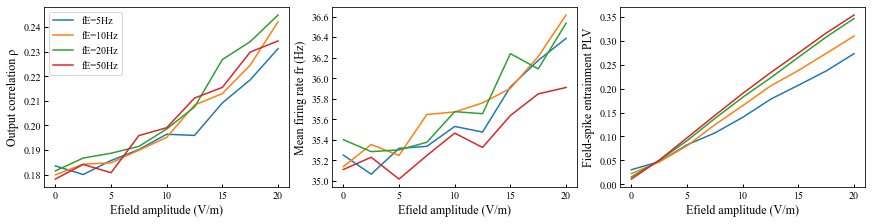

In [1130]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
for i in range(len(list_fE)):
    ax[0].plot(list_AE, data_rou[i].mean(axis=0), label='fE=%dHz' % list_fE[i])
    ax[1].plot(list_AE, data_fr[i].mean(axis=0))
    ax[2].plot(list_AE, data_plv[i].mean(axis=0))
ax[0].legend(fontsize=10)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[1].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)
ax[2].set_ylabel('Field-spike entrainment PLV', fontsize=12)
for item in ax:
    item.set_xlabel('Efield amplitude (V/m)', fontsize=12)

In [1131]:
fEindex = 0
list_pValue = []
for i in range(1, len(list_AE)):
    _, pValue = scipy.stats.ttest_ind(data_fr[fEindex][:, 0], data_fr[fEindex][:, i])
    list_pValue.append(pValue)
print('放电率显著性水平：', list_pValue)

list_pValue = []
for i in range(1, len(list_AE)):
    _, pValue = scipy.stats.ttest_ind(data_rou[fEindex][:, 0], data_rou[fEindex][:, i])
    list_pValue.append(pValue)
print('相关性显著性水平：', list_pValue)

list_pValue = []
for i in range(1, len(list_AE)):
    _, pValue = scipy.stats.ttest_ind(data_plv[fEindex][:, 0], data_plv[fEindex][:, i])
    list_pValue.append(pValue)
print('PLV显著性水平：', list_pValue)

放电率显著性水平： [0.44892307403986775, 0.7941830309701138, 0.746023873465558, 0.29840219770531784, 0.36941372769064273, 0.011930707166046174, 0.00018349082993989444, 7.290804382052668e-06]
相关性显著性水平： [0.4228940934832581, 0.6135855164750756, 0.12892941101531818, 0.003368693238498003, 0.004378246855254522, 7.133637235122758e-08, 9.525475320872447e-13, 3.3953494766143985e-20]
PLV显著性水平： [4.1640749726205366e-07, 1.0929364910374478e-26, 5.106688011823613e-41, 8.980305258197555e-56, 2.7294984408054113e-61, 1.1539831436740994e-71, 5.0089603620830717e-79, 3.845859809424858e-86]


## Figure 5-2: 电场频率对相关性的影响

In [185]:
list_AE = [5, 10, 20]
list_fE = np.hstack((np.arange(2, 60, 2), np.arange(60, 101, 4)))
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE5-10-20_fE2-100.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 1, 0, 2)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 1, 0, 2)[1]
data_plv = res.transpose(3, 1, 0, 2)[3]
res.shape

(50, 3, 40, 5)

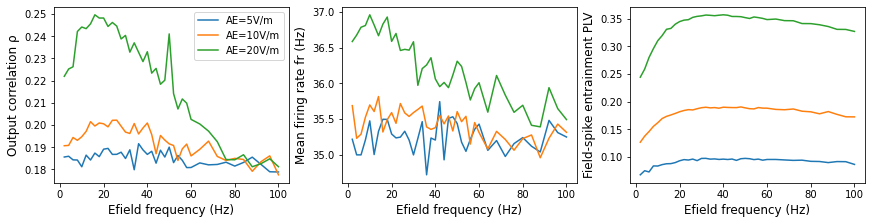

In [189]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
for i in range(len(list_AE)):
    ax[0].plot(list_fE, data_rou[i].mean(axis=0), label='AE=%dV/m' % list_AE[i])
    ax[1].plot(list_fE, data_fr[i].mean(axis=0))
    ax[2].plot(list_fE, data_plv[i].mean(axis=0))
ax[0].legend(fontsize=10)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[1].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)
ax[2].set_ylabel('Field-spike entrainment PLV', fontsize=12)
for item in ax:
    item.set_xlabel('Efield frequency (Hz)', fontsize=12)

# Figure 6: 在输入固定下，验证电场是否通过PLV调节相关性

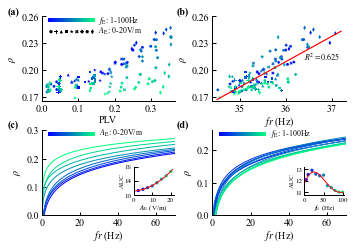

In [184]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth

fig, ax = plt.subplots(2, 2, figsize=(5, 3.5))
ax0, ax1, ax2, ax3 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

list_AE = np.arange(0, 20+1, 2.5)
list_fE = [2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-20_fE2-100.npy')
res     = res.squeeze().mean(axis=0).transpose(2, 0, 1)
data_rou, data_fr, data_plv = res[2], res[1], res[3]
colorLength = len(list_fE)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
markerList = ['o', 'P', '^','s', '*', 'X', 'D', 'H', 'd']
markerSizeList = np.array([3, 6, 4, 1, 10, 5, 1, 5, 5]) + 5

'''Figure 6(a): 输出相关性——PLV之间关系'''
for i in range(len(list_AE)):
    for j in range(len(list_fE)):
        ax0.scatter(data_plv[i, j], data_rou[i, j], marker=markerList[i], s=markerSizeList[i], color=colors[j], ec=None)
ax0.set_ylim(0.165, 0.26)
ax0.set_yticks(np.arange(0.17, 0.261, 0.03))
ax0.set_xlim(0, 0.365)

'''Figure 6(b): 输出相关性——放电率之间关系，固定输入'''
for i in range(len(list_AE)):
    for j in range(len(list_fE)):
        ax1.scatter(data_fr[i, j], data_rou[i, j], marker=markerList[i], s=markerSizeList[i], color=colors[j], ec=None)

x, y = data_fr.flatten(), data_rou.flatten()
xtemp       = sorted(enumerate(x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
xsort = np.array(multi_piker(x))
ysort = np.array(multi_piker(y))
init_values = [0.1 for i in range(2)]
best_vals, covar = curve_fit(poly1fit, xsort, ysort, p0=init_values, maxfev = 1000000)
xfit        = np.arange(34.5, 37.2, 0.01)
yfit        = poly1fit(xfit, *best_vals)
ax1.plot(xfit, yfit, color='r', lw=1.2)

ax1.set_ylim(0.165, 0.26)
ax1.set_yticks(np.arange(0.17, 0.261, 0.03))
ax1.set_xlim(34.4, 37.3)
ax1.text(36.4, 0.21, r'$R^2=0.625$', fontsize=8)


########################################################################################################################
########################################################################################################################
list_mu    = np.arange(8, 20 + 0.1, 2)
list_sigma = np.arange(15, 55 + 1, 5)
list_AE    = np.arange(2.5, 20+1, 2.5)
list_fE    = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res        = np.load('data/times10_c03_mu8-20pA_sigma15-55pA_AE0-20_fE5-100.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, AE, fE, results)
data = res.transpose(5, 3, 4, 0, 1, 2)  # shape = (results, AE, fE, times, mu, sigma)
'''Figure 6(c): 输出相关性——放电率之间关系，固定电场频率10Hz'''
data_AE = data[:, :, 1, :, :, :] # 10Hz shape= (results, AE, times, mu, sigma) = (5, 8, 10, 7, 9)
list_x, list_y, list_xfit, list_yfit, list_area1 = [], [], [], [], []
for i in range(len(list_AE)):
    data_rou, data_fr = data_AE[2][i], data_AE[1][i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
    ain1, bin1, cin1 = best_vals[0], best_vals[1], best_vals[2]
    def powerfit_givenparams(x, ain1=ain1, bin1=bin1, cin1=cin1):
        return ain1*x**bin1 + cin1
    list_area1.append(integrate.quad(powerfit_givenparams, xfit[0], 70)[0])
    
colorLength = len(list_x)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
for i in range(colorLength):
    ax2.plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1)
ax2.set_ylim(0, 0.3)
ax2.set_xlim(-0.1, 70)

'''Figure 6(d): 输出相关性——放电率之间关系，固定电场强度10V/m'''
data_fE = data[:, 3, :, :, :, :] # 10V/m shape= (results, Af, times, mu, sigma) = (5, 8, 10, 7, 9)
list_x, list_y, list_xfit, list_yfit, list_area2 = [], [], [], [], []
for i in range(len(list_fE)):
    data_rou, data_fr = data_fE[2][i], data_fE[1][i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
    ain1, bin1, cin1 = best_vals[0], best_vals[1], best_vals[2]
    def powerfit_givenparams(x, ain1=ain1, bin1=bin1, cin1=cin1):
        return ain1*x**bin1 + cin1
    list_area2.append(integrate.quad(powerfit_givenparams, xfit[0], 70)[0])
colorLength = len(list_x)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
for i in range(colorLength):
    ax3.plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1)
ax3.set_ylim(0, 0.26)
ax3.set_xlim(-0.1, 70)

for item in [ax0, ax1, ax2, ax3]:
    item.tick_params(pad=3)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_ylabel(r'$\rho$', fontsize=10, labelpad=3)
ax0.set_xlabel(r'PLV', fontsize=10, labelpad=1)
ax1.set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=1)
ax2.set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=1)
ax3.set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=1)

plt.tight_layout(w_pad=0.3, h_pad=0.1)

fig.text(0.03, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.50, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.03, 0.5, '(c)', fontsize=10, fontweight='bold')
fig.text(0.50, 0.5, '(d)', fontsize=10, fontweight='bold')


###################################################
###################################################
colorLength = len(list_area1)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
ax2in = ax2.inset_axes([0.69, 0.24, 0.3, 0.33])
ax2in.scatter(list_AE, list_area1, s=5, color=colors)
xfit = np.arange(0, 21, 0.1)
yfit = poly2fit(xfit, *[0.0122, 0.03829, 11.05])
ax2in.plot(xfit, yfit, color='r', lw=1)
ax2in.set_xlim(0, 21.5)
ax2in.set_ylim(10, 18)
ax2in.set_xticks([0, 10, 20])
ax2in.set_yticks([10, 14, 18])
ax2in.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=7, labelpad=0)
ax2in.set_ylabel(r'AUC', fontsize=7, labelpad=0)

###################################################
###################################################
colorLength = len(list_area2)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
ax3in = ax3.inset_axes([0.69, 0.24, 0.3, 0.33])
ax3in.scatter(list_fE, list_area2, s=5, color=colors)
xfit = np.arange(0, 101, 0.5)
yfit = gauss2fit(xfit, *[9.005, 7.344, 67.08, 11.34, 151.2, 128.9])
ax3in.plot(xfit, yfit, color='r', lw=1)
ax3in.set_xlim(0, 104)
ax3in.set_ylim(10.8, 13.2)
ax3in.set_xticks([0, 50, 100])
ax3in.set_yticks([11, 12, 13])
ax3in.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=7, labelpad=0)
ax3in.set_ylabel(r'AUC', fontsize=7, labelpad=0)

for item in [ax2in, ax3in]:
    item.tick_params(pad=2, labelsize=7)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)

###################################################
###################################################
list_AE = np.arange(0, 20+1, 2.5)
list_fE = np.array([2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
ax0in = ax0.inset_axes([0.05, 0.93, 0.35, 0.05])
norm = Normalize(vmin=1, vmax=100)
cmap = plt.cm.get_cmap('winter')
scalar_mappable = ScalarMappable(cmap=cmap, norm=norm)
cbar0 = plt.colorbar(scalar_mappable, cax=ax0in, orientation='horizontal', ticks=[])
ax0in.axis('off')

ax0in1 = ax0.inset_axes([0.05, 0.77, 0.35, 0.1])
ax0in1.set_xlim(-0.5, 8.5)
ax0in1.set_ylim(0, 1)
for i in range(len(list_AE)):
    ax0in1.scatter(i, 0.5, marker=markerList[i], s=markerSizeList[i]+3, color='k', ec=None)
ax0in1.axis('off')

ax0.text(0.155, 0.253, r'$\mathit{f}_{\mathrm{E}}$: 1-100Hz', fontsize=8)
ax0.text(0.155, 0.241, r'$\mathit{A}_{\mathrm{E}}$: 0-20V/m', fontsize=8)

###################################################
###################################################
list_AE    = np.arange(2.5, 20+1, 2.5)
list_fE    = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax2in = ax2.inset_axes([0.05, 0.93, 0.35, 0.05])
norm = Normalize(vmin=0, vmax=20)
cmap = plt.cm.get_cmap('winter')
scalar_mappable = ScalarMappable(cmap=cmap, norm=norm)
cbar2 = plt.colorbar(scalar_mappable, cax=ax2in, orientation='horizontal', ticks=[])
ax2in.axis('off')

ax3in = ax3.inset_axes([0.05, 0.93, 0.35, 0.05])
norm = Normalize(vmin=1, vmax=100)
cmap = plt.cm.get_cmap('winter')
scalar_mappable = ScalarMappable(cmap=cmap, norm=norm)
cbar3 = plt.colorbar(scalar_mappable, cax=ax3in, orientation='horizontal', ticks=[])
ax3in.axis('off')

ax2.text(30, 0.28, r'$\mathit{A}_{\mathrm{E}}$: 0-20V/m', fontsize=8)
ax3.text(30, 0.242, r'$\mathit{f}_{\mathrm{E}}$: 1-100Hz', fontsize=8)

plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure6.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

# 电场调节放电序列相关性机制解释

## 仅仅在树突引入正弦输入

In [341]:
list_AE = np.arange(0, 31, 2.5)
list_fE = np.arange(5, 101, 10)
res     = np.load('data/onlyDendriticSineWave_times20_c03_mu14pA_sigma35pA_AE0-30_fE5-10-100.npy')
res     = res.squeeze()  # shape=(times, amplitude, frequency, results)
data_c   = res.mean(axis=0).transpose(2, 0, 1)[0]  # shape=(amplitude, frequency)
data_fr  = res.mean(axis=0).transpose(2, 0, 1)[1]
data_rou = res.mean(axis=0).transpose(2, 0, 1)[2]
data_plv = res.mean(axis=0).transpose(2, 0, 1)[3]
data_mu  = res.mean(axis=0).transpose(2, 0, 1)[5]
data_std = res.mean(axis=0).transpose(2, 0, 1)[6]

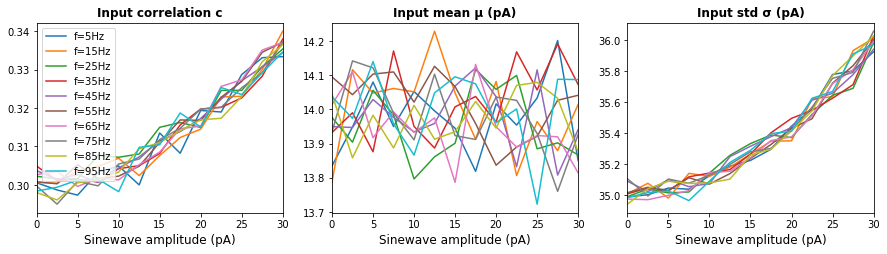

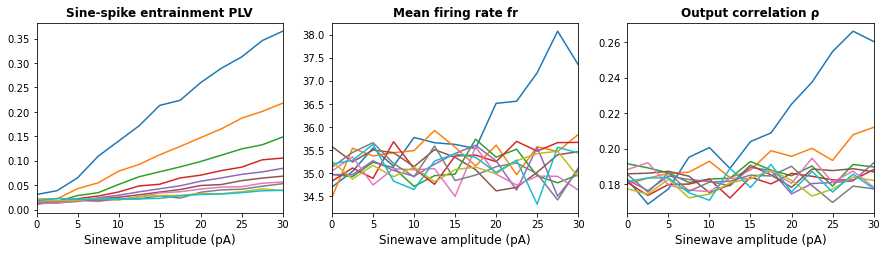

In [342]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_c[:, i], label='f=%dHz' % list_fE[i])
    ax[1].plot(list_AE, data_mu[:, i])
    ax[2].plot(list_AE, data_std[:, i])
ax[0].legend(fontsize=10)
ax[0].set_title('Input correlation c', fontsize=12, weight='bold')
ax[1].set_title('Input mean μ (pA)', fontsize=12, weight='bold')
ax[2].set_title('Input std σ (pA)', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)



fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_plv[:, i])
    ax[1].plot(list_AE, data_fr[:, i])
    ax[2].plot(list_AE, data_rou[:, i])
ax[0].set_title('Sine-spike entrainment PLV', fontsize=12, weight='bold')
ax[1].set_title('Mean firing rate fr', fontsize=12, weight='bold')
ax[2].set_title('Output correlation ρ', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)

## 仅仅在胞体引入正弦输入

In [334]:
list_AE  = np.arange(0, 31, 2.5)
list_fE  = np.arange(5, 101, 10)
res      = np.load('data/onlySomaticSineWave_times20_c03_mu14pA_sigma35pA_AE0-30_fE5-10-100.npy')
res      = res.squeeze()  # shape=(times, amplitude, frequency, results)
data_c   = res.mean(axis=0).transpose(2, 0, 1)[0]  # shape=(amplitude, frequency)
data_fr  = res.mean(axis=0).transpose(2, 0, 1)[1]
data_rou = res.mean(axis=0).transpose(2, 0, 1)[2]
data_plv = res.mean(axis=0).transpose(2, 0, 1)[3]

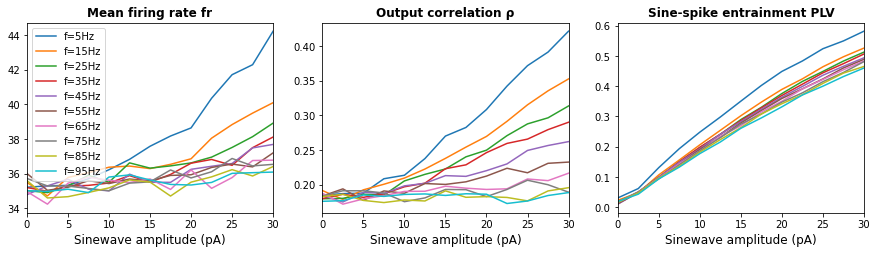

In [339]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_fr[:, i], label='f=%dHz' % list_fE[i])
    ax[1].plot(list_AE, data_rou[:, i])
    ax[2].plot(list_AE, data_plv[:, i])
ax[0].legend(fontsize=10)
ax[0].set_title('Mean firing rate fr', fontsize=12, weight='bold')
ax[1].set_title('Output correlation ρ', fontsize=12, weight='bold')
ax[2].set_title('Sine-spike entrainment PLV', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)

In [4]:
%%time
if not os.path.exists('data/SineWaveStd_A0-30_f5-100.npy'):
    dt = 0.01 / 1e3  # second
    duration = 40  # second
    tvar = np.arange(0, duration, dt)  # second
    Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C
    list_AE = np.arange(0, 31, 2.5)
    list_fE = np.arange(5, 101, 10)
    listStd = np.zeros((len(list_AE), len(list_fE)))
    for i in range(len(list_AE)):
        for j in range(len(list_fE)):
            AE, fE, phiE = list_AE[i], list_fE[j], 0
            waveform = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE) * 1e12
            listStd[i, j] = waveform.std()
    np.save('data/SineWaveStd_A0-30_f5-100.npy', listStd)

Wall time: 8.6 s


Text(0, 0.5, 'Stimulation frequency (Hz)')

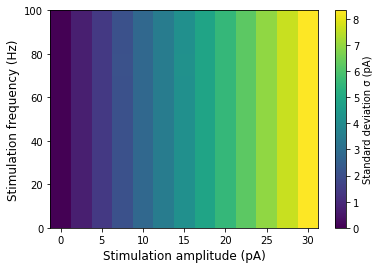

In [11]:
data = np.load('data/SineWaveStd_A0-30_f5-100.npy')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ipm = ax.pcolormesh(list_AE, list_fE, data.transpose(), shading='auto')
cbar = plt.colorbar(ipm, ax=ax, label='Standard deviation σ (pA)')
ax.set_xlabel('Stimulation amplitude (pA)', fontsize = 12)
ax.set_ylabel('Stimulation frequency (Hz)', fontsize = 12)

## 树突和胞体都引入正弦刺激

In [343]:
list_AE = np.arange(0, 31, 2.5)
list_fE = np.arange(5, 101, 10)
res     = np.load('data/SomaticAndDendriticSineWave_times20_c03_mu14pA_sigma35pA_AE0-30_fE5-10-100.npy')
res     = res.squeeze()  # shape=(times, amplitude, frequency, results)
data_c   = res.mean(axis=0).transpose(2, 0, 1)[0]  # shape=(amplitude, frequency)
data_fr  = res.mean(axis=0).transpose(2, 0, 1)[1]
data_rou = res.mean(axis=0).transpose(2, 0, 1)[2]
data_plv = res.mean(axis=0).transpose(2, 0, 1)[3]
data_mu  = res.mean(axis=0).transpose(2, 0, 1)[5]
data_std = res.mean(axis=0).transpose(2, 0, 1)[6]

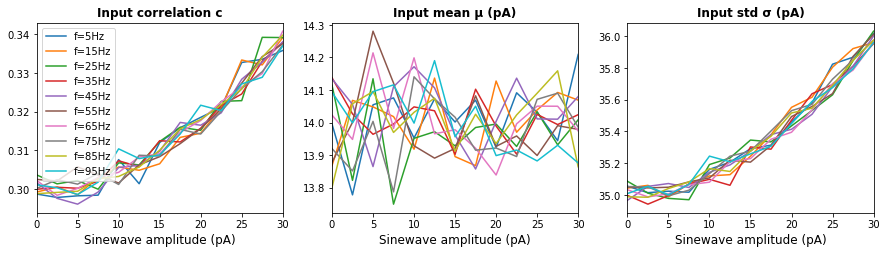

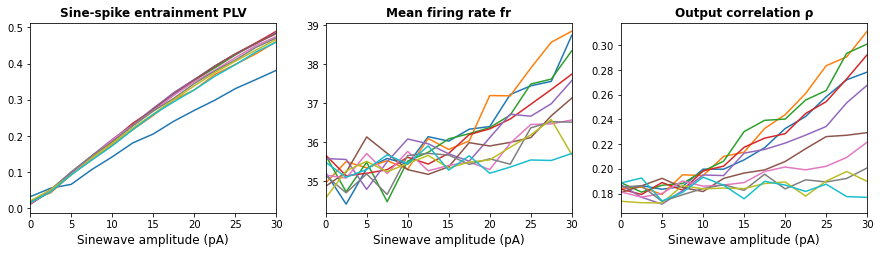

In [344]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_c[:, i], label='f=%dHz' % list_fE[i])
    ax[1].plot(list_AE, data_mu[:, i])
    ax[2].plot(list_AE, data_std[:, i])
ax[0].legend(fontsize=10)
ax[0].set_title('Input correlation c', fontsize=12, weight='bold')
ax[1].set_title('Input mean μ (pA)', fontsize=12, weight='bold')
ax[2].set_title('Input std σ (pA)', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)


fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_plv[:, i])
    ax[1].plot(list_AE, data_fr[:, i])
    ax[2].plot(list_AE, data_rou[:, i])
ax[0].set_title('Sine-spike entrainment PLV', fontsize=12, weight='bold')
ax[1].set_title('Mean firing rate fr', fontsize=12, weight='bold')
ax[2].set_title('Output correlation ρ', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)

## 引入电场作用

In [12]:
list_AE  = np.arange(0, 31, 2.5)
list_fE  = np.arange(5, 101, 10)
res      = np.load('data/EfieldStimulation_times20_c03_mu14pA_sigma35pA_AE0-30_fE5-10-100.npy')
res      = res.squeeze()  # shape=(times, amplitude, frequency, results)
data_c   = res.mean(axis=0).transpose(2, 0, 1)[0]  # shape=(amplitude, frequency)
data_fr  = res.mean(axis=0).transpose(2, 0, 1)[1]
data_rou = res.mean(axis=0).transpose(2, 0, 1)[2]
data_plv = res.mean(axis=0).transpose(2, 0, 1)[3]

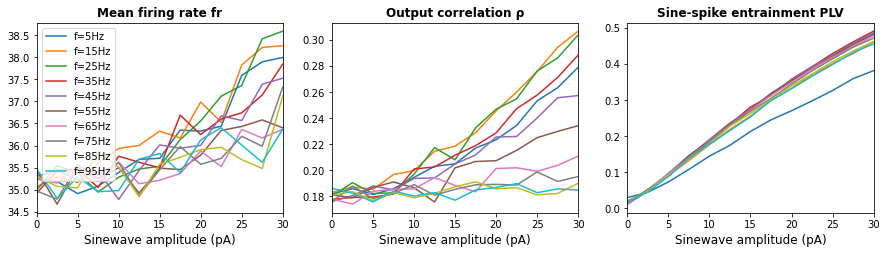

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for i in range(0, len(list_fE)):
    ax[0].plot(list_AE, data_fr[:, i], label='f=%dHz' % list_fE[i])
    ax[1].plot(list_AE, data_rou[:, i])
    ax[2].plot(list_AE, data_plv[:, i])
ax[0].legend(fontsize=10)
ax[0].set_title('Mean firing rate fr', fontsize=12, weight='bold')
ax[1].set_title('Output correlation ρ', fontsize=12, weight='bold')
ax[2].set_title('Sine-spike entrainment PLV', fontsize=12, weight='bold')
for item in ax:
    item.set_xlim(0, 30)
    item.set_xlabel('Sinewave amplitude (pA)', fontsize=12)

## 树突正弦刺激输入引起胞体正弦响应时，相位差随刺激频率的变化情况

In [34]:
%%time
dt       = 0.01 / 1e3  # second
duration = 10  # second
tvar     = np.arange(0, duration, dt)
AE       = 30
list_fE  = np.arange(2, 101, 2)
Is       = np.zeros_like(tvar)
Evar     = np.zeros_like(tvar)
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C
list_vsvd, list_vsstim, list_vdstim = [], [], []
for i in range(len(list_fE)):
    fE = list_fE[i]
    Id = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar)
    vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    index_vsoma_lastpeak = find_peaks(vsoma)[0][-1]
    index_vdend_lastpeak = find_peaks(vdend)[0][-1]
    index_stim_lastpeak  = find_peaks(Id)[0][-1]
    dPhase_vs_vd    = ((tvar[index_vsoma_lastpeak] - tvar[index_vdend_lastpeak]) * fE * (180/np.pi) + 360) % 360
    dPhase_vs_stim  = ((tvar[index_vsoma_lastpeak] - tvar[index_stim_lastpeak]) * fE * (180/np.pi) + 360) % 360
    dPhase_vd_stim  = ((tvar[index_vdend_lastpeak] - tvar[index_stim_lastpeak]) * fE * (180/np.pi) + 360) % 360
    list_vsvd.append(dPhase_vs_vd)
    list_vsstim.append(dPhase_vs_stim)
    list_vdstim.append(dPhase_vd_stim)

Wall time: 2.22 s


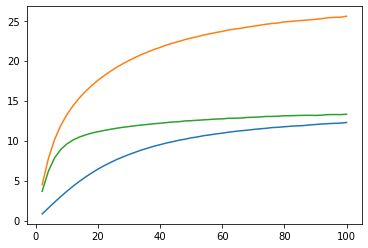

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(list_fE, list_vsvd)
ax.plot(list_fE, list_vsstim)
ax.plot(list_fE, list_vdstim)

## 电场诱发的极化响应：幅频特性和相频特性

In [5]:
%%time
dt       = 0.01 / 1e3  # second
duration = 10  # second
tvar     = np.arange(0, duration, dt)
AE       = 30
list_fE  = np.arange(2, 101, 2)
Is       = np.zeros_like(tvar)
Id       = np.zeros_like(tvar)
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C
amp_freq_soma, amp_freq_dend     = [], []
phase_freq_soma, phase_freq_dend = [], []




list_vsvd, list_vsstim, list_vdstim = [], [], []
for i in range(len(list_fE)):
    fE = list_fE[i]
    Evar = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar)
    vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    index_vsoma_lastpeak = find_peaks(vsoma)[0][-1]
    index_vdend_lastpeak = find_peaks(vdend)[0][-1]
    index_stim_lastpeak  = find_peaks(Evar)[0][-1]
    dPhase_vs_vd    = ((tvar[index_vsoma_lastpeak] - tvar[index_vdend_lastpeak]) * fE * (180/np.pi) + 360) % 360
    dPhase_vs_stim  = ((tvar[index_vsoma_lastpeak] - tvar[index_stim_lastpeak]) * fE * (180/np.pi) + 360) % 360
    dPhase_vd_stim  = ((tvar[index_vdend_lastpeak] - tvar[index_stim_lastpeak]) * fE * (180/np.pi) + 360) % 360
    list_vsvd.append(dPhase_vs_vd)
    list_vsstim.append(dPhase_vs_stim)
    list_vdstim.append(dPhase_vd_stim)

Wall time: 2.88 s


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(list_fE, list_vsvd)
ax.plot(list_fE, list_vsstim)
ax.plot(list_fE, list_vdstim)

In [6]:
dt       = 0.01 / 1e3  # second
duration = 10  # second
tvar     = np.arange(0, duration, dt)
AE = 30
list_fE = np.arange(2, 101, 2)
list_phiE = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
mat_std1 = np.zeros((len(list_fE), len(list_phiE)))
mat_std2 = np.zeros((len(list_fE), len(list_phiE)))
for i in range(len(list_fE)):
    for j in range(len(list_phiE)):
        fE, phiE = list_fE[i], list_phiE[j]
        sinewave1 = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar)
        sinewave2 = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
        mud, sigmad, c = 14, 35, 0.3
        Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
        Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
        Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
        Id1, Id2 = Id1*1e-12, Id2*1e-12 
        
        std1 = np.std(sinewave1)
        std2 = np.std(sinewave1 + sinewave2)
        mat_std1[i, j] = std1
        mat_std2[i, j] = std2

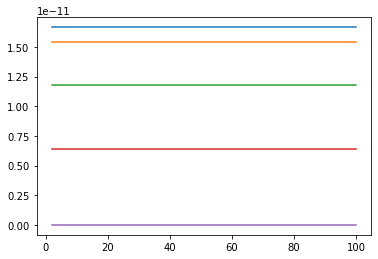

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(len(list_phiE)):
    ax.plot(list_fE, mat_std2[:, i])

# Results 3.4: 引入正弦输入探究对输入相关性的影响

In [113]:
%%time
dt       = 0.01/1e3                     # second
duration = 10                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 30, 5, 0
c, mud, sigmad = 0.3, 5, 5             # pA
Is   = np.zeros_like(tvar)              # A
Idsin= Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12 + Idsin, Id2*1e-12 + Idsin         # A
Evar = np.zeros_like(tvar)
vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
spikeNumber, firingRate, spikeInds, outputSpikeTimes = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)

Wall time: 299 ms


In [114]:
firingRate

1.3000013000013

In [127]:
%%time
list_AE = np.arange(0, 31, 5)
list_c  = []
for i in range(len(list_AE)):
    AE, fE, phiE   = list_AE[i], 10, 0
    c, mud, sigmad = 0.3, 14, 35
    dt       = 0.01/1e3                     # second
    duration = 40                           # second
    tvar     = np.arange(0, duration, dt)   # second
    Idsin= Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12 + Idsin, Id2*1e-12 + Idsin         # A
    list_c.append(pearsonr(Id1, Id2)[0])

Wall time: 5.21 s


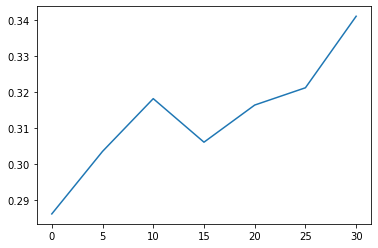

In [128]:
plt.plot(list_AE, list_c)

In [129]:
31801.480422258377/3600

8.833744561738438

# Figure 8: 证明共振效应与双向极化相关

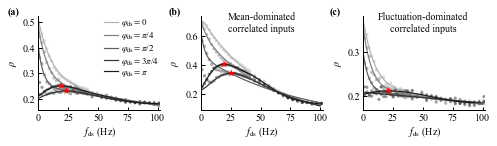

In [62]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
lw=1.2
size=10
alpha=0.5
starsize=60
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax0, ax1, ax2 = ax[0], ax[1], ax[2]

########################################################################################################################################
# Figure 9(a)
########################################################################################################################################
list_fE  = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
addrList = ['data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-00pi.npy', 'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-25pi.npy',
            'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-50pi.npy', 'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-75pi.npy',
            'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-100pi.npy']
labelList = [r'$\mathit{\varphi}_{\mathrm{ds}}=$0', r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$/4', r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$/2', 
             r'$\mathit{\varphi}_{\mathrm{ds}}=$3$\pi$/4',  r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$']
# colors=['#0072BD', '#D95319', '#77AC30',  '#A2142F', '#7E2F8E']
colors=['#B2B2B2', '#808080', '#5F5F5F', '#333333', '#1C1C1C']
for i in range(5):
    res      = np.load(addrList[i])
    res      = res.transpose(0, 3, 2, 1) # shape=(results, times, frequency, phi)
    data_rou = res.mean(axis=0)[2]
    if i<=2:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[0][:]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss2fit(xfit, *[0.1049, 11.88, 44.04, 0.1785, 91.5, 123.8])
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
        ax0.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
    else:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss3fit(xfit, *[0.1205, 10.02, 28.94, 0.06303, 47.93, 34.96, 0.2, 175.6, 200.3])
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax0.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
ax0.legend(fontsize=9, frameon=False, labelspacing=0.08, handletextpad=0.4, borderpad=0.1, handlelength=1.5, borderaxespad=0)
########################################################################################################################################
# Figure 9(b): mean-dominated input
########################################################################################################################################
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu20pA_sigma15pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]
for i in range(5):
    if i<=2:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss2fit(xfit, *[-0.513, -14.05, 27.31, 5.956e12, -3639, 665.5])
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
        ax1.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
    else:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss4fit(xfit, *[0.2554, 31.3, 32.31, 0, 28.27, 6.776e-3, 0.1316, 85.57, 79.28, 0.1442, 11.4, 16.88])
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax1.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)


########################################################################################################################################
# Figure 9(c): fluctuation-dominated input
########################################################################################################################################
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu8pA_sigma55pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]

for i in range(5):
    if i<=1:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==2:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *[0.08479, -0.2163, 0.2107, -0.001541])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = poly1fit(xfit, *[-0.0002418, 0.2074])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    else:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 93, 0.1)
        yfit        = poly3fit(xfit, *[1.428e-7, -2.443e-5, 8.407e-4, 0.2024])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax2.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)


for item in ax:
    item.set_xlim(0, 102)
    item.set_xticks(np.arange(0, 102, 25))
    item.set_xlabel(r'$\mathit{f}_{\mathrm{ds}}$ (Hz)', fontsize=10, labelpad=2)
    item.set_ylabel(r'$\rho$', fontsize=10, labelpad=4)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.tick_params(pad=3)


plt.tight_layout(w_pad=0, h_pad=0)
fig.text(0.02, 0.94, '(a)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.94, '(b)', fontsize=10, fontweight='bold')
fig.text(0.66, 0.94, '(c)', fontsize=10, fontweight='bold')
fig.text(0.525, 0.82, 'Mean-dominated\ncorrelated inputs', fontsize=10, horizontalalignment='center')
fig.text(0.845, 0.82, 'Fluctuation-dominated\ncorrelated inputs', fontsize=10, horizontalalignment='center')

plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure8.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

Text(0, 0.5, 'Output correlation ρ')

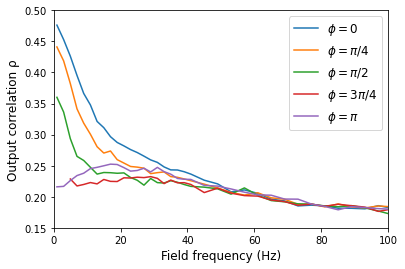

In [4]:
list_fE  = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
res      = np.load('data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-00pi.npy')
res      = res.transpose(0, 3, 2, 1) # shape=(results, times, frequency, phi)
data_rou = res.mean(axis=0)[2]
ax.plot(list_fE[:], data_rou[0][:], label=r'$\phi=0$')

res      = np.load('data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-25pi.npy')
res      = res.transpose(0, 3, 2, 1)  
data_fr  = res.mean(axis=0)[1]
data_rou = res.mean(axis=0)[2]
ax.plot(list_fE[:], data_rou[0][:], label=r'$\phi=\pi/4$')

res      = np.load('data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-50pi.npy')
res      = res.transpose(0, 3, 2, 1) 
data_fr  = res.mean(axis=0)[1]
data_rou = res.mean(axis=0)[2]
ax.plot(list_fE[:], data_rou[0][:], label=r'$\phi=\pi/2$')

res      = np.load('data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-75pi.npy')
res      = res.transpose(0, 3, 2, 1) 
data_fr  = res.mean(axis=0)[1]
data_rou = res.mean(axis=0)[2]
ax.plot(list_fE[2:], data_rou[0][2:], label=r'$\phi=3\pi/4$')

res      = np.load('data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-100pi.npy')
res      = res.transpose(0, 3, 2, 1)
data_fr  = res.mean(axis=0)[1]
data_rou = res.mean(axis=0)[2]
ax.plot(list_fE[:], data_rou[0][:], label=r'$\phi=\pi$')

ax.legend(fontsize=12)
ax.set_xlim(0, 100)
ax.set_ylim(0.15, 0.5)
ax.set_xlabel('Field frequency (Hz)', fontsize=12)
ax.set_ylabel('Output correlation ρ', fontsize=12)

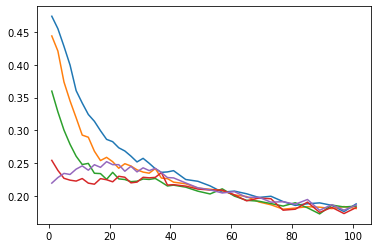

In [5]:
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]
data_rou.shape
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(5):
    ax.plot(list_fE, data_rou[:, i], label=r'$\phi=0$')

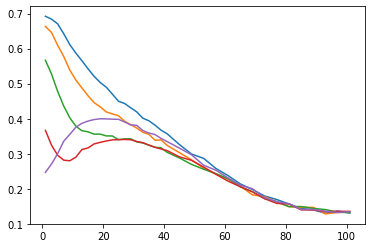

In [6]:
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu20pA_sigma15pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]
data_rou.shape
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(5):
    ax.plot(list_fE, data_rou[:, i], label=r'$\phi=0$')

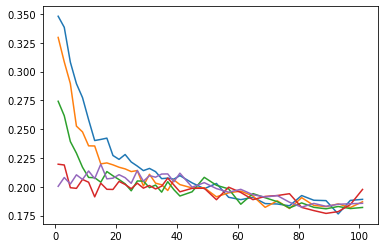

In [9]:
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu8pA_sigma55pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]
data_rou.shape
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(5):
    ax.plot(list_fE, data_rou[:, i], label=r'$\phi=0$')

# Figure 9: 用真实神经元复现上述两间室模型产生的结果

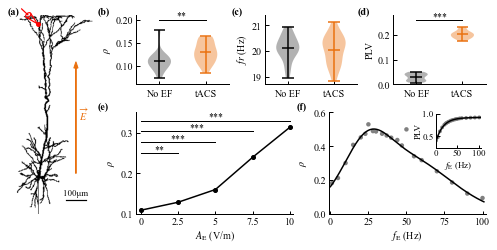

In [61]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1

fig = plt.figure(figsize=(7, 3.5))
shape0, shape1 = 7, 8
ax0 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,0), rowspan=7, colspan=2)
ax1 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,2), rowspan=3, colspan=2)
ax2 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,4), rowspan=3, colspan=2)
ax3 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,6), rowspan=3, colspan=2)
ax4 = plt.subplot2grid(shape=(shape0, shape1), loc=(3,2), rowspan=4, colspan=3)
ax5 = plt.subplot2grid(shape=(shape0, shape1), loc=(3,5), rowspan=4, colspan=3)


'''Figure 9(a): Neuron model'''
photo =Image.open('data/LarkumModel.png')
ax0.imshow(photo, origin='upper')
ax0.set_xlim(ax0.get_xlim()[0]-0, ax0.get_xlim()[1]+0)
ax0.set_ylim(ax0.get_ylim()[0]+0, ax0.get_ylim()[1]-0)
# ax0.scatter(44, 320, color='k', s=15) # soma
ax0.scatter(41, 16, color='r', s=15)
ax0.plot([95, 95+75/2], [350, 350], color='k', lw=1.2)
ax0.text(89.5, 343, r'100μm', fontsize=9)
ax0.arrow(95+75/4, 300, 0, -200, width=0.9, color='#EA700E', head_width=8)
ax0.text(95+75/4+5, 200, r'$\overrightarrow{E}$', fontsize=10, color='#EA700E', fontweight='bold')
ax0.axis('off')

'''Figure 9(b-d): 交流电场能够改变相关性、放电率、PLV'''
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1]
data_rou = res.transpose(2, 0, 1)[2]
data_plv = res.transpose(2, 0, 1)[3]

idx = 1
positions = np.array([0, 1])
pc1 = ax1.violinplot(data_rou[:, [0, idx]], positions=positions, showmeans=True)
ax1.set_xticks(positions, labels=['No EF', 'tACS'], fontsize=10)
ax1.set_yticks(np.arange(0.1, 0.21, 0.05))
ax1.set_ylim(0.06, 0.21)

pc2 = ax2.violinplot(data_fr[:, [0, idx]], positions=positions, showmeans=True)
ax2.set_xticks(positions, labels=['No EF', 'tACS'], fontsize=10)
ax2.set_yticks(np.arange(19, 21.1, 1))
ax2.set_ylim(19-0.3, 21.4)

pc3 = ax3.violinplot(data_plv[:, [0, idx]], positions=positions, showmeans=True)
ax3.set_xticks(positions, labels=['No EF', 'tACS'], fontsize=10)
ax3.set_yticks(np.arange(0, 0.21, 0.1))
ax3.set_ylim(0, 0.28)

ax1.set_ylabel(r'$\rho$', fontsize=10, labelpad=3)
ax2.set_ylabel('$fr$ (Hz)', fontsize=10, labelpad=3)
ax3.set_ylabel('PLV', fontsize=10, labelpad=3)
for item in [ax1, ax2, ax3]:
    item.tick_params('y', pad=3)
    item.tick_params('x', pad=4)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_xlim(0-0.5, 1+0.5)
colors = ['grey', '#EA700E']
for pci in [pc1, pc2, pc3]:
    pci['cmeans'].set_color(['k', '#EA700E'])
    pci['cmaxes'].set_color(['k', '#EA700E'])
    pci['cmins'].set_color(['k', '#EA700E'])
    pci['cbars'].set_color(['k', '#EA700E'])

    pci['bodies'][0].set_facecolor('grey')
    pci['bodies'][0].set_alpha(0.6)
    pci['bodies'][1].set_facecolor('#EA700E')
    pci['bodies'][1].set_alpha(0.4)
ax1.plot([0, 1], [0.2, 0.2], lw=1, color='k')
ax1.text(0.36, .2, '**', fontsize=10)
ax3.plot([0, 1], [0.26, 0.26], lw=1, color='k')
ax3.text(0.36, .26, '***', fontsize=10)



'''Figure 9(e): 电场强度如何影响相关性'''
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
ax4.plot(list_AE, data_rou, marker='o', ms=4, color='k', lw=1.5)
ax4.set_xticks([0, 2.5, 5, 7.5, 10], ['0', '2.5', '5', '7.5', '10'])
ax4.set_yticks([0.1, 0.2, 0.3])
ax4.set_xlim(-0.3, 10.2)
ax4.set_ylim(0.1, 0.35)
ax4.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=2)
ax4.set_ylabel(r'$\rho$', fontsize=10)

ylist = np.linspace(0.25, 0.33, 4)
ax4.plot([0, 2.5], [ylist[0], ylist[0]], lw=1, color='k')
ax4.text(0.92, ylist[0], '**', fontsize=10)
ax4.plot([0, 5], [ylist[1], ylist[1]], lw=1, color='k')
ax4.text(2, ylist[1], '***', fontsize=10)
ax4.plot([0, 7.5], [ylist[2], ylist[2]], lw=1, color='k')
ax4.text(3.25, ylist[2], '***', fontsize=10)
ax4.plot([0, 10], [ylist[3], ylist[3]], lw=1, color='k')
ax4.text(4.5, ylist[3], '***', fontsize=10)



'''Figure 9(f): 电场频率如何影响相关性'''
list_fE = [1, 5, 10, 15, 20, 25] + [30, 40, 50, 60] + [70, 80, 90, 100] + [23, 28, 34, 37, 44, 47, 55]
addr0 = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res1  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE30-40-50-60_apic63.npy')
res2  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE70-80-90-100_apic63.npy')
res3  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE23-28-34-37-44-47-55_apic63.npy')
res4  = np.load(addr).squeeze()
res = np.concatenate((res1, res2, res3, res4), axis=1)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
xfit = np.arange(0, 101, 0.1)
matlab_paras = [0.2335, 23.51, 19.86, 0.3403, 47.11, 43.34]
yfit = gauss2fit(xfit, *matlab_paras)
ax5.scatter(list_fE, data_rou, s=20, ec=None, fc='grey', alpha=1)
ax5.plot(xfit, yfit, color='k', lw=1.5)
ax5.set_xticks(np.arange(0, 101, 25))
ax5.set_xlim(-1, 102)
ax5.set_yticks(np.arange(0, 0.61, 0.2))
ax5.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=2)
ax5.set_ylabel(r'$\rho$', fontsize=10)

for item in [ax4, ax5]:
    item.tick_params(pad=3)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
plt.tight_layout(w_pad=0.3, h_pad=1)

fig.text(0.02, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.20, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.465, 0.95, '(c)', fontsize=10, fontweight='bold')
fig.text(0.715, 0.95, '(d)', fontsize=10, fontweight='bold')
fig.text(0.20, 0.57, '(e)', fontsize=10, fontweight='bold')
fig.text(0.595, 0.57, '(f)', fontsize=10, fontweight='bold')

'''Figure 9(a)-supplyment'''
ax01 = fig.add_axes((0.05-0.003, 0.905+0.007, 0.033, 0.062))
ax01.set_xticks([]); ax01.set_yticks([])
ax01.set_xlim(-5, 100)
ax01.set_ylim(0, 105)
lw=1.2
centerx, centery = 40+2, 60-2
circlePatch = mpatches.Ellipse((centerx, centery), 40, 25, ec='r', lw=lw, fill=False, angle=45)
ax01.add_artist(circlePatch)
ax01.plot([35, 100], [40, 0], color='r', lw=lw)
ax01.plot([60, 100], [65, 0], color='r', lw=lw)
ax01.plot([0, 40], [100, 60], color='r', lw=lw)
ax01.axis('off')


ax51 = fig.add_axes([0.87, 0.42, 0.09, 0.135])

xfit = np.arange(0, 104, 0.5)
yfit = exp2fit(xfit, *[0.9085, 0.0001131, -0.5484, -0.06174])
ax51.scatter(list_fE, data_plv, s=15, ec=None, fc='grey', alpha=1)
ax51.plot(xfit, yfit, color='k', lw=1.5)
ax51.tick_params(pad=2, labelsize=9)
ax51.spines['top'].set_color('none')
ax51.spines['right'].set_color('none')
ax51.spines['bottom'].set_linewidth(linewidth)
ax51.spines['left'].set_linewidth(linewidth)
ax51.set_ylim(0.25, 1)
ax51.set_xlim(0, 104)
ax51.set_xticks([0, 50, 100])
ax51.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=9, labelpad=1)
ax51.set_ylabel(r'PLV', fontsize=9, labelpad=0)


plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure9.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

In [56]:
np.array(list_fE), data_plv

(array([  1,   5,  10,  15,  20,  25,  30,  40,  50,  60,  70,  80,  90,
        100,  23,  28,  34,  37,  44,  47,  55]),
 array([0.40725183, 0.48199974, 0.61252486, 0.6986795 , 0.75680128,
        0.79706606, 0.82476615, 0.86370625, 0.88628654, 0.90246868,
        0.90628047, 0.91291608, 0.91656289, 0.91876882, 0.78324576,
        0.81495551, 0.84453609, 0.85416306, 0.87385863, 0.88240781,
        0.89709775]))

In [184]:
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_rou = res.transpose(2, 0, 1)[2]
list_pValue = []
for i in range(1, len(list_AE)):
    _, pValue = scipy.stats.ttest_ind(data_rou[:, 0], data_rou[:, i])
    list_pValue.append(pValue)
print('相关性显著性水平：', list_pValue)

相关性显著性水平： [0.006709318676587149, 5.870429320983365e-09, 1.7008905093837402e-20, 1.7830189761167077e-27]


0.006709318676587149 0.7365553401416913 4.438862346554709e-31


Text(0.5, 1.0, 'p=4.63e-31')

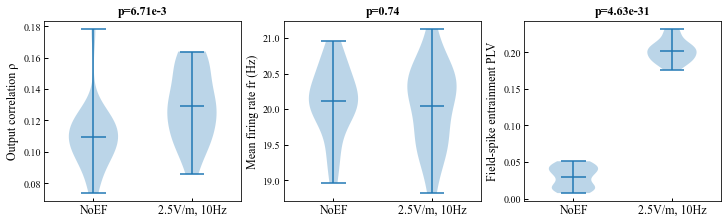

In [180]:
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1]
data_rou = res.transpose(2, 0, 1)[2]
data_plv = res.transpose(2, 0, 1)[3]
data_fr.shape

# 显著性检验
tStat1, pValue1 = scipy.stats.ttest_ind(data_rou[:, 0], data_rou[:, 1])
tStat2, pValue2 = scipy.stats.ttest_ind(data_fr[:, 0], data_fr[:, 1])
tStat3, pValue3 = scipy.stats.ttest_ind(data_plv[:, 0], data_plv[:, 1])
print(pValue1, pValue2, pValue3 )
# 绘图
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
positions = np.array([0, 1])
ax[0].violinplot(data_rou[:, [0, idx]], positions=positions, showmeans=True)
ax[0].set_xticks(positions, labels=['NoEF', '2.5V/m, 10Hz'], fontsize=12)
# ax[0].set_yticks(np.arange(0.07, 0.20, 0.04))
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
# ax[0].set_ylim(0.07, 0.20)

ax[1].violinplot(data_fr[:, [0, idx]], positions=positions, showmeans=True)
ax[1].set_xticks(positions, labels=['NoEF', '2.5V/m, 10Hz'], fontsize=12)
# ax[1].set_yticks(np.arange(31, 41, 2))
ax[1].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)
# ax[1].set_ylim(18.5, 21.5)

ax[2].violinplot(data_plv[:, [0, idx]], positions=positions, showmeans=True)
ax[2].set_xticks(positions, labels=['NoEF', '2.5V/m, 10Hz'], fontsize=12)
# ax[2].set_yticks(np.arange(0, 0.31, 0.05))
ax[2].set_ylabel('Field-spike entrainment PLV', fontsize=12)
# ax[2].set_ylim(0, 0.3)
for item in ax:
    item.set_xlim(-0.5, 1.5)

ax[0].set_title('p=6.71e-3', fontsize=12, weight='bold')
ax[1].set_title('p=0.74', fontsize=12, weight='bold')
ax[2].set_title('p=4.63e-31', fontsize=12, weight='bold')

In [91]:
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)

In [130]:
list_fE = [1, 5, 10, 15, 20, 25]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
res.shape

(10, 6, 5)

Text(0, 0.5, 'Output correlation ρ')

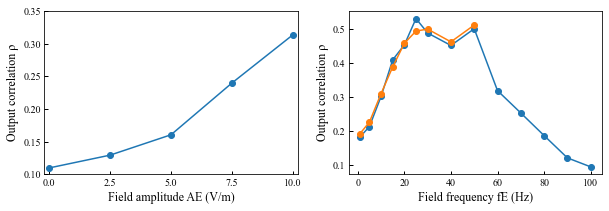

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
ax[0].plot(list_AE, data_rou, marker='o')
ax[0].set_xticks([0, 2.5, 5, 7.5, 10])
ax[0].set_xlim(-0.2, 10.2)
ax[0].set_ylim(0.1, 0.35)
ax[0].set_xlabel('Field amplitude AE (V/m)', fontsize=12)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)



list_fE = [1, 5, 10, 15, 20, 25] + [30, 40, 50, 60] + [70, 80, 90, 100]
addr0 = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res1  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE30-40-50-60_apic63.npy')
res2  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE70-80-90-100_apic63.npy')
res3  = np.load(addr).squeeze()

res = np.concatenate((res1, res2, res3), axis=1)
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)


list_fE2 = [1, 5, 10, 15, 20, 25, 30, 40, 50]
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-50_dend25.npy')
res4  = np.load(addr).squeeze()
data_rou2 = res4.transpose(2, 0, 1)[2].mean(axis=0)

ax[1].plot(list_fE, data_rou, marker='o')
ax[1].plot(list_fE2, data_rou2, marker='o')
# ax[1].set_xlim(0, 100)
# ax[1].set_ylim(0.1, 0.35)
ax[1].set_xlabel('Field frequency fE (Hz)', fontsize=12)
ax[1].set_ylabel('Output correlation ρ', fontsize=12)

In [172]:
A1 = 10
A2 = A1 * np.arange(0.02, 1, 0.02)
phi1 = np.arange(-np.pi, np.pi, 0.02)

In [173]:
listamp = np.zeros((len(A2), len(phi1)))
for i in range(len(A2)):
    for j in range(len(phi1)):
        listamp[i, j] = np.sqrt(A1**2 + A2[i]**2 + 2*A1*A2[i]*np.cos(phi1[j]))

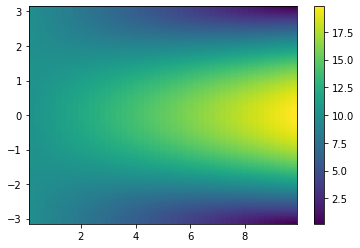

In [174]:
plt.pcolormesh(A2, phi1, listamp.transpose())
plt.colorbar()